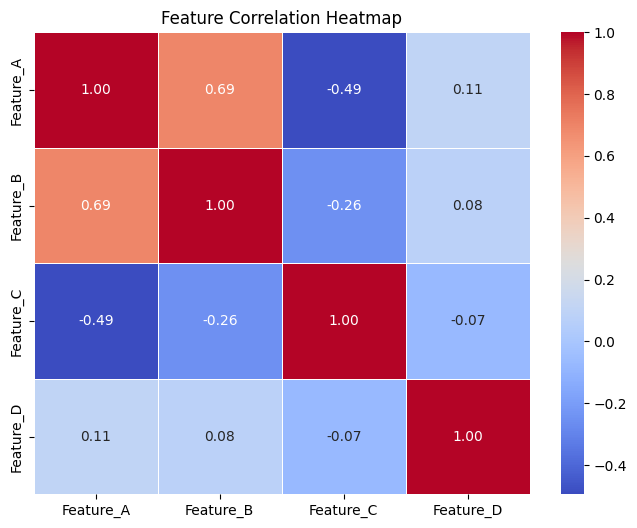

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 feature 是一个包含特征的 DataFrame
# 计算相关性矩阵
correlation_matrix = feature.corr()

# 设置图形大小
plt.figure(figsize=(12, 8))

# 使用 Seaborn 绘制热力图
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)

# 添加标题
plt.title("Feature Correlation Heatmap")

# 显示图形
plt.show()

In [7]:
import lightgbm as lgb
from sklearn.model_selection import KFold # Changed from train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from tqdm import tqdm

def train_lgbm_model_cv(data, feature, selected_features, target='return_diff_shifted',
                        start_date='2016-01-01', end_date='2023-12-31',
                        n_splits=5, # Number of CV folds
                        cv_shuffle=True, # Shuffle for KFold
                        cv_random_state=21, # Random state for KFold shuffle
                        # LGBM 参数
                        n_estimators=2000,
                        learning_rate=0.001,
                        max_depth=-1,
                        num_leaves=31,
                        min_child_samples=20,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        reg_alpha=0.1,
                        reg_lambda=0.1,
                        early_stopping_rounds=50,
                        verbose_eval=100 # Controls LGBM's own logging frequency during training
                       ):
    """
    使用交叉验证训练LGBM模型，并返回按性能排序的模型列表和RMSE列表。

    :param data: 处理后的数据 (Pandas DataFrame, 索引为日期时间)
    :param feature: 添加特征后的数据 (Pandas DataFrame, 索引为日期时间)
    :param selected_features: 选择的特征列表
    :param target: 目标变量列名
    :param start_date: 数据开始日期
    :param end_date: 数据结束日期
    :param n_splits: 交叉验证的折数.
    :param cv_shuffle: KFold 是否打乱数据. 对于时间序列，通常建议 False，除非有特定理由.
                     如果为 False，cv_random_state 将无意义.
    :param cv_random_state: KFold 打乱数据时的随机种子.
    :param n_estimators: 树的数量
    :param learning_rate: 学习率
    :param max_depth: 树的最大深度
    :param num_leaves: 每棵树的叶子节点数
    :param min_child_samples: 叶子节点最小样本数
    :param subsample: 数据子采样比例
    :param colsample_bytree: 特征子采样比例
    :param reg_alpha: L1 正则化系数
    :param reg_lambda: L2 正则化系数
    :param early_stopping_rounds: 提前停止的轮数
    :param verbose_eval: 控制LGBM评估日志的频率 (e.g., 100 means print every 100 rounds).
                         -1 or False to disable.
    :return: (model_list, rmse_list) - 模型列表和对应的RMSE列表，按RMSE升序排列 (从好到坏)
    """
    data_df = data.copy()
    feature_df = feature.copy()

    # 确保索引是 DateTimeIndex 类型
    if not isinstance(data_df.index, pd.DatetimeIndex):
        data_df.index = pd.to_datetime(data_df.index)
    if not isinstance(feature_df.index, pd.DatetimeIndex):
        feature_df.index = pd.to_datetime(feature_df.index)

    # 选择数据范围
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)

    data_df = data_df[(data_df.index >= start_dt) & (data_df.index <= end_dt)]
    feature_df = feature_df[(feature_df.index >= start_dt) & (feature_df.index <= end_dt)]

    # 准备 X 和 y
    X_full = feature_df[selected_features]
    y_full = data_df[target]

    # 合并后删除缺失值，确保 X 和 y 对齐
    temp_df_full = pd.concat([X_full, y_full], axis=1).dropna()
    X = temp_df_full[selected_features]
    y = temp_df_full[target]

    if X.empty or y.empty:
        print("数据为空，请检查日期范围、特征选择或缺失值处理。")
        return [], []

    # 初始化交叉验证器
    # 注意: 对于时间序列数据，TimeSeriesSplit 通常是更好的选择，以避免数据泄露。
    # KFold(shuffle=False) 也可以按顺序划分，但 TimeSeriesSplit 更专门。
    # 如果使用 KFold 且 shuffle=True (如原函数中的 train_test_split)，请确保这符合您的数据特性。
    kf = KFold(n_splits=n_splits, shuffle=cv_shuffle, random_state=cv_random_state if cv_shuffle else None)

    model_list = []
    rmse_list = []

    print(f"开始进行 {n_splits}-折交叉验证...")

    for fold_idx, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"\n--- 开始 Fold {fold_idx + 1}/{n_splits} ---")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # 创建LGBM模型实例
        model = lgb.LGBMRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=cv_random_state + fold_idx if cv_random_state is not None else None, # Vary random state per fold if base is set
            verbose=-1, # Suppress LGBM's own verbose, rely on callbacks and verbose_eval in fit
        )

        # LightGBM Callbacks
        callbacks = []
        if early_stopping_rounds > 0:
            callbacks.append(lgb.early_stopping(
                stopping_rounds=early_stopping_rounds,
                verbose=1 if verbose_eval >=0 else 0 # Print early stopping message if verbose_eval is not silencing all
            ))
        
        # Control fit's verbosity through eval_period for log_evaluation like behavior
        # Note: LGBMRegressor's verbose param is different from verbose in fit/callbacks
        # We will use fit's eval_period for printing evaluation results
        
        print(f"Fold {fold_idx+1}: 开始训练模型，最多 {n_estimators} 轮迭代...")
        
        # tqdm setup for iterations within this fold
        # The actual number of iterations might be less due to early stopping.
        with tqdm(total=n_estimators, desc=f"Fold {fold_idx+1} Training", unit="iter", leave=False) as pbar:
            eval_results_for_pbar = {} # To store latest eval results for pbar

            def tqdm_update_callback(env):
                pbar.update(1)
                # Store results for pbar description
                # env.evaluation_result_list is like: [('Train', 'rmse', 1.23, True), ('Val', 'rmse', 1.56, True)]
                if env.evaluation_result_list:
                    for eval_name_tuple in env.evaluation_result_list:
                        eval_name, metric_name, metric_val, _ = eval_name_tuple
                        if eval_name == 'Val': # We named our validation set 'Val'
                             eval_results_for_pbar[f"{eval_name}_{metric_name}"] = metric_val
                
                desc_parts = [f"Iter: {env.iteration}/{n_estimators}"]
                if 'Val_rmse' in eval_results_for_pbar:
                     desc_parts.append(f"Val RMSE: {eval_results_for_pbar['Val_rmse']:.4f}")
                pbar.set_description(", ".join(desc_parts))
            
            final_callbacks = callbacks + [tqdm_update_callback]

            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_names=['Train', 'Val'], # Renamed 'Test' to 'Val' as it's a validation set
                eval_metric='rmse',
                callbacks=final_callbacks,
                # verbose parameter in fit controls evaluation logging frequency
                # set to verbose_eval if it's positive, otherwise disable (False)
                # verbose=False in fit disables printing. Use a number for frequency.
                # verbose=True prints every round if early_stopping_rounds is also used.
                # We use callbacks for more control, so verbose in fit can be tricky.
                # lgb.log_evaluation callback is generally preferred.
                # However, if we want to use the fit's verbose, ensure it aligns.
                # Let's remove `lgb.log_evaluation` and use fit's `verbose` (renamed `eval_period`)
            )
            # To use fit's built-in verbose for evaluation metrics:
            # model.fit(..., verbose=verbose_eval if verbose_eval > 0 else False)
            # and remove lgb.log_evaluation from callbacks.
            # The current setup with tqdm_update_callback and early_stopping verbose is usually sufficient.


        # If early stopping occurred, model is already at best iteration.
        if early_stopping_rounds > 0 and model.best_iteration_ is not None:
            print(f"Fold {fold_idx + 1}: 模型在第 {model.best_iteration_} 轮迭代时达到最佳性能 (提前停止).")
        
        # 预测验证集
        y_pred_val = model.predict(X_val)

        # 计算该折的均方根误差
        fold_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        print(f"Fold {fold_idx + 1} Validation RMSE: {fold_rmse:.4f}")

        model_list.append(model)
        rmse_list.append(fold_rmse)
        pbar.close() # Ensure tqdm pbar for the fold is closed

    print("\n--- 交叉验证全部完成 ---")

    # 按RMSE对模型和RMSE列表进行排序 (从好到坏)
    if rmse_list:
        sorted_indices = np.argsort(rmse_list)
        model_list_sorted = [model_list[i] for i in sorted_indices]
        rmse_list_sorted = [rmse_list[i] for i in sorted_indices]
        
        print("按RMSE排序后的各折结果 (从好到坏):")
        for i, rmse_val in enumerate(rmse_list_sorted):
            # Find original fold index for clarity if needed, though sort order is primary
            original_fold_idx_for_this_rank = sorted_indices[i]
            print(f"  排序 {i+1} (原Fold {original_fold_idx_for_this_rank + 1}): RMSE = {rmse_val:.4f}")
        return model_list_sorted, rmse_list_sorted
    else:
        print("交叉验证未产生任何结果。")
        return [], []


if __name__ == '__main__':
    # 创建用于演示的虚拟数据
    dates_index = pd.date_range(start='2015-12-01', end='2024-01-31', freq='B') # 工作日
    num_samples = len(dates_index)
    
    # 模拟特征和目标
    sim_data = pd.DataFrame(index=dates_index)
    sim_data['featureA'] = np.random.rand(num_samples) * 100 + np.arange(num_samples) * 0.1
    sim_data['featureB'] = np.random.randn(num_samples) * 50 - np.arange(num_samples) * 0.05
    sim_data['featureC'] = np.sin(np.linspace(0, 50, num_samples)) * 20
    sim_data['return_diff_shifted'] = np.random.randn(num_samples) * 0.05 + sim_data['featureA']*0.001 - sim_data['featureB']*0.0005

    # 引入一些缺失值
    for col in sim_data.columns:
        nan_mask = np.random.choice([True, False], size=num_samples, p=[0.05, 0.95])
        sim_data.loc[nan_mask, col] = np.nan
    
    print(f"虚拟数据创建完毕，总样本数: {num_samples}")
    print(f"目标 'return_diff_shifted' 非空值数量: {sim_data['return_diff_shifted'].notna().sum()}")

    selected_features_example = ['featureA', 'featureB', 'featureC']

    # `data` DataFrame 包含目标变量
    # `feature` DataFrame 包含特征变量
    # 在此示例中，它们是同一个 DataFrame
    
    # 确保在调用前数据已准备好
    if sim_data[selected_features_example].isna().any().any() or sim_data['return_diff_shifted'].isna().any():
        print("注意: 虚拟数据中仍存在NaN，函数内部的dropna会处理。")

    print("\n开始调用 train_lgbm_model_cv 函数...")
    trained_models, model_rmses = train_lgbm_model_cv(
        data=sim_data.copy(), 
        feature=sim_data.copy(), 
        selected_features=selected_features_example,
        target='return_diff_shifted',
        start_date='2016-01-01',
        end_date='2023-12-31',
        n_splits=3, # 减少折数以便快速演示
        cv_shuffle=True, # 对于非严格时序数据，打乱可能更好
        cv_random_state=42,
        n_estimators=150, # 减少树的数量以便快速演示
        learning_rate=0.05,
        early_stopping_rounds=20,
        verbose_eval=50 # 每50轮在tqdm中更新RMSE
    )

    if trained_models:
        print(f"\n模型训练完成。总共训练了 {len(trained_models)} 个模型。")
        print("各模型RMSE (已排序，从好到坏):")
        for i, rmse_score in enumerate(model_rmses):
            print(f"  Model Rank {i+1}: RMSE = {rmse_score:.4f}")
        
        # 获取性能最佳的模型 (列表中的第一个)
        best_overall_model = trained_models[0]
    else:
        print("\n模型训练失败或没有模型返回。")

虚拟数据创建完毕，总样本数: 2132
目标 'return_diff_shifted' 非空值数量: 2030
注意: 虚拟数据中仍存在NaN，函数内部的dropna会处理。

开始调用 train_lgbm_model_cv 函数...
开始进行 3-折交叉验证...

--- 开始 Fold 1/3 ---
Fold 1: 开始训练模型，最多 150 轮迭代...


Iter: 31/150, Val RMSE: 0.0675:  21%|██▏       | 32/150 [00:00<00:00, 175.52iter/s]

Training until validation scores don't improve for 20 rounds


Early stopping, best iteration is:
[113]	Train's rmse: 0.0434559	Train's l2: 0.00188842	Val's rmse: 0.0580049	Val's l2: 0.00336457
Fold 1: 模型在第 113 轮迭代时达到最佳性能 (提前停止).
Fold 1 Validation RMSE: 0.0580

--- 开始 Fold 2/3 ---
Fold 2: 开始训练模型，最多 150 轮迭代...


Iter: 37/150, Val RMSE: 0.0576:  25%|██▌       | 38/150 [00:00<00:00, 213.94iter/s]

Training until validation scores don't improve for 20 rounds


Early stopping, best iteration is:
[85]	Train's rmse: 0.0444459	Train's l2: 0.00197544	Val's rmse: 0.0556468	Val's l2: 0.00309657
Fold 2: 模型在第 85 轮迭代时达到最佳性能 (提前停止).
Fold 2 Validation RMSE: 0.0556

--- 开始 Fold 3/3 ---
Fold 3: 开始训练模型，最多 150 轮迭代...


Iter: 35/150, Val RMSE: 0.0677:  24%|██▍       | 36/150 [00:00<00:00, 178.61iter/s]

Training until validation scores don't improve for 20 rounds


Early stopping, best iteration is:
[114]	Train's rmse: 0.0420779	Train's l2: 0.00177055	Val's rmse: 0.0598281	Val's l2: 0.0035794
Fold 3: 模型在第 114 轮迭代时达到最佳性能 (提前停止).
Fold 3 Validation RMSE: 0.0598

--- 交叉验证全部完成 ---
按RMSE排序后的各折结果 (从好到坏):
  排序 1 (原Fold 2): RMSE = 0.0556
  排序 2 (原Fold 1): RMSE = 0.0580
  排序 3 (原Fold 3): RMSE = 0.0598

模型训练完成。总共训练了 3 个模型。
各模型RMSE (已排序，从好到坏):
  Model Rank 1: RMSE = 0.0556
  Model Rank 2: RMSE = 0.0580
  Model Rank 3: RMSE = 0.0598
